In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import time
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import hour, minute

In [ ]:
for key, value in os.environ.items():
    print(f'{key} = {value}')

SHELL = /bin/bash
NV_LIBCUBLAS_VERSION = 11.11.3.6-1
NVIDIA_VISIBLE_DEVICES = all
COLAB_JUPYTER_TRANSPORT = ipc
NV_NVML_DEV_VERSION = 11.8.86-1
NV_CUDNN_PACKAGE_NAME = libcudnn8
CGROUP_MEMORY_EVENTS = /sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events
NV_LIBNCCL_DEV_PACKAGE = libnccl-dev=2.15.5-1+cuda11.8
NV_LIBNCCL_DEV_PACKAGE_VERSION = 2.15.5-1
VM_GCE_METADATA_HOST = 169.254.169.253
HOSTNAME = a9669415dba2
LANGUAGE = en_US
TBE_RUNTIME_ADDR = 172.28.0.1:8011
GCE_METADATA_TIMEOUT = 3
NVIDIA_REQUIRE_CUDA = cuda>=11.8 brand=tesla,driver>=450,driver<451 brand=tesla,driver>=470,driver<471 brand=unknown,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=geforce,driver>=470,driver<471 brand=geforcertx,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=titan,driver>=470,driver<471 brand=titanrtx,driver>=470,driver<471 brand=tesla,driver>=510,driver<511 brand=unk

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cloudpath = '/content/drive/MyDrive/cloud/assignment3'

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import concat, col, lit, to_timestamp, unix_timestamp

In [ ]:
#data loading, timestamp crrating and dropoff......
taxi_data_main = spark.read.csv(f'{cloudpath}/nyc_taxi.csv', header=True, inferSchema=True)
taxi_data_main = taxi_data_main.withColumn('pickup_timestamp', to_timestamp(concat(col('pickup_date'), lit(' '), col('pickup_time')), 'M/d/yyyy H:mm'))
taxi_data_main = taxi_data_main.withColumn('dropoff_timestamp', to_timestamp(concat(col('dropoff_date'), lit(' '), col('dropoff_time')), 'M/d/yyyy H:mm'))
taxi_data_main = taxi_data_main.withColumn('duration', ((unix_timestamp(col('dropoff_timestamp'), 'yyyy-MM-dd HH:MM:SS')-unix_timestamp(col('pickup_timestamp'), 'yyyy-MM-dd HHMM:SS'))/60).cast(IntegerType()))
taxi_data_main.show(5)

+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+--------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|   pickup_timestamp|  dropoff_timestamp|duration|
+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+--------+
|   1/1/2017|       0:00|    1/1/2017|        0:00|    0.02| 0.0| 52.8|2017-01-01 00:00:00|2017-01-01 00:00:00|       0|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.5| 0.0|  5.3|2017-01-01 00:00:00|2017-01-01 00:03:00|       3|
|   1/1/2017|       0:00|    1/1/2017|        0:39|    7.75|4.66|27.96|2017-01-01 00:00:00|2017-01-01 00:39:00|      39|
|   1/1/2017|       0:00|    1/1/2017|        0:06|     0.8|1.45| 8.75|2017-01-01 00:00:00|2017-01-01 00:06:00|       6|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9| 0.0|  8.3|2017-01-01 00:00:00|2017-01-01 00:08:00|       8|
+-----------+-----------+-------

Q1 Using Spark MLlib build a model to predict taxi fare from trip distance (Model: M1)

In [ ]:
#vector creation . . . .

assembler = VectorAssembler(inputCols=["distance"], outputCol="features")
taxi_data = assembler.transform(taxi_data_main)

(training_data, testing_data) = taxi_data.randomSplit([0.7, 0.3], seed=29)
lr = LinearRegression(featuresCol="features", labelCol="fare")
model1 = lr.fit(training_data)

predictions = model1.transform(testing_data)
predictions.show(5)

+-----------+-----------+------------+------------+--------+----+----+-------------------+-------------------+--------+--------+------------------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip|fare|   pickup_timestamp|  dropoff_timestamp|duration|features|        prediction|
+-----------+-----------+------------+------------+--------+----+----+-------------------+-------------------+--------+--------+------------------+
|   1/1/2017|       0:00|    1/1/2017|        0:01|     0.1| 0.0| 4.3|2017-01-01 00:00:00|2017-01-01 00:01:00|       1|   [0.1]| 7.244393569177446|
|   1/1/2017|       0:00|    1/1/2017|        0:01|    0.41|0.72|5.52|2017-01-01 00:00:00|2017-01-01 00:01:00|       1|  [0.41]| 8.212508013817123|
|   1/1/2017|       0:00|    1/1/2017|        0:06|    0.79|1.82|9.12|2017-01-01 00:00:00|2017-01-01 00:06:00|       6|  [0.79]|  9.39922894595608|
|   1/1/2017|       0:00|    1/1/2017|        0:07|    0.65| 1.7| 9.5|2017-01-01 00:00:00|2017-01-01 00:07:00|  

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import hour, minute

# Feature engg. . . . .
taxi_data_main = taxi_data_main.withColumn('hour_of_day_pickup', hour(col('pickup_time')))
taxi_data_main = taxi_data_main.withColumn('minute_of_hour_pickup', minute(col('pickup_time')))
taxi_data_main = taxi_data_main.withColumn('hour_of_day_dropoff', hour(col('dropoff_time')))
taxi_data_main = taxi_data_main.withColumn('minute_of_hour_dropoff', minute(col('dropoff_time')))

#  feature columns. . . .
feature_columns = ["distance", "hour_of_day_pickup", "minute_of_hour_pickup", "hour_of_day_dropoff", "minute_of_hour_dropoff", "fare"]

# Vector Assembler. . . .
assembler = VectorAssembler(inputCols=feature_columns[:-1], outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# Linear R Model. . . .
lr = LinearRegression(featuresCol="features", labelCol="fare")


pipeline = Pipeline(stages=[assembler, scaler, lr])

# Param Grid for Hyperparameter Tuning. . . . .
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-Validation. . . . .
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="fare", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)

#training data. . . .
cvModel = crossval.fit(taxi_data_main)

predictions = cvModel.transform(taxi_data_main)

# Create the evaluator
evaluator = RegressionEvaluator(labelCol="fare", predictionCol="prediction", metricName="rmse")

# Evaluate the model. . . .
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 526.0583604767365


Q2 Using Spark MLlib build a model to predict taxi fare from trip distance and trip duration in minutes (Model: M2). M2 will have two features

What is the fare of a 20 mile long trip using M1

What is the fare of a 14 mile trip that took 75 minutes using M2

Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?
Use M2 to answer this question

In [ ]:
assembler = VectorAssembler(inputCols=["distance", "duration"], outputCol="features")
taxi_data = assembler.transform(taxi_data_main)
(training_data, testing_data) = taxi_data.randomSplit([0.7, 0.3], seed=29)

lr = LinearRegression(featuresCol="features", labelCol="fare")
model2 = lr.fit(training_data)


predictions = model2.transform(testing_data)

evaluator = RegressionEvaluator(labelCol="fare", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 6.097568036503722


fare for 20 miles trip by using m1......

In [ ]:
from pyspark.ml.linalg import Vectors
#fare of a 20 mile long trip using M1. . . . . . .
fare = model1.predict(Vectors.dense([[20]]))
formatted_fare1=round(fare, 2)
print("the fare of a 20 mile long trip using model M1 is", formatted_fare1)

the fare of a 20 mile long trip using model M1 is 69.39


fare for 14 miles trip for 75 minutes using m2. . .

In [ ]:
fare = model2.predict(Vectors.dense([14, 75]))

formatted_fare = round(fare, 2)

print("Fare of 14-mile trip with M2:", formatted_fare)


Fare of 14-mile trip with M2: 51.06


Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?

In [ ]:
First_fare = model2.predict(Vectors.dense([[10, 40]]))
Second_Fare = model2.predict(Vectors.dense([[13, 25]]))

if First_fare > Second_Fare:
    print("Fare for 10-mile trip taking 40 minutes is higher")
else:
    print("Fare for 13-mile trip taking 25 minutes is higher")

Fare for 13-mile trip taking 25 minutes is higher


average tip amount

In [ ]:
average_tip = taxi_data_main.agg({"tip": "avg"}).collect()[0][0]

formatted_average_tip = round(average_tip, 3)

print("Average tip amount:", formatted_average_tip)


Average tip amount: 1.699


During which hour the city experiences the most number of trips?

In [ ]:
from pyspark.sql.functions import hour

# Extract the hour from the pickup time
taxi_data = taxi_data_main.withColumn("pickup_hour", hour("pickup_time"))

# Group the data by pickup hour. . . .
hourly_trip_counts = taxi_data.groupBy("pickup_hour").count()

sorted_hourly_trip_counts = hourly_trip_counts.sort("count", ascending=False)

most_busy_hour = sorted_hourly_trip_counts.first()["pickup_hour"]

# Convert to AM/PM format
if most_busy_hour >= 12:
    am_pm = "PM"
    most_busy_hour = most_busy_hour - 12 if most_busy_hour > 12 else most_busy_hour
else:
    am_pm = "AM"

print("The most number of trips occur during hour", most_busy_hour, am_pm)


The most number of trips occur during hour 5 PM


Compare Spark’s performance
Divide the data into 10 parts: 10%, 20%, …, 100%
Plot of time taken by M2 model

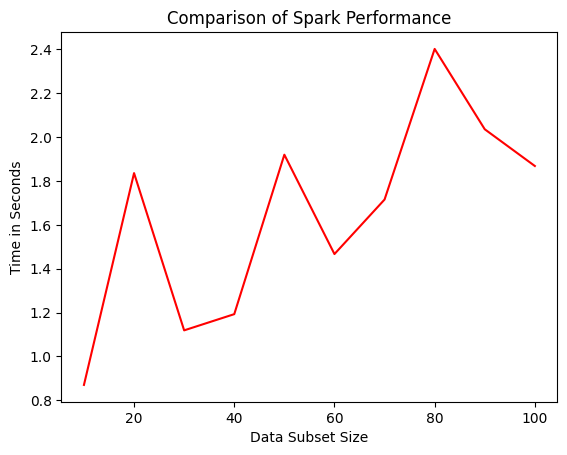

In [ ]:
import time
import matplotlib.pyplot as plt

# Defining a list of percentages. . . . .
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Define the operation to time..  . . .
def hours_count(data):
    data = data.withColumn('pickup_hour', hour('pickup_time'))
    hourly_trip_counts = data.groupBy('pickup_hour').count()
    sorted_hourly_trip_counts = hourly_trip_counts.sort('count', ascending=False)
    return sorted_hourly_trip_counts.first()['count']

times = []

for p in percentages:
    subset = taxi_data_main.limit(int(taxi_data_main.count() * p / 100))
    start_time = time.time()
    hours_count(subset)
    end_time = time.time()
    times.append(end_time - start_time)

# Plot the results. . . . . . . . . .
plt.plot(percentages, times, color= 'red' )
plt.title('Comparison of Spark Performance')
plt.xlabel('Data Subset Size')
plt.ylabel('Time in Seconds')
plt.show()


In [ ]:
execution_times = []

for percentage in range(10, 110, 10):
    num_rows = int(taxi_data_main.count() * percentage / 100)

    subset_data = taxi_data_main.limit(num_rows)

    start_time = time.time()

    subset_data = subset_data.withColumn('hour_of_day_pickup', hour(col('pickup_time')))
    subset_data = subset_data.withColumn('minute_of_hour_pickup', minute(col('pickup_time')))
    subset_data = subset_data.withColumn('hour_of_day_dropoff', hour(col('dropoff_time')))
    subset_data = subset_data.withColumn('minute_of_hour_dropoff', minute(col('dropoff_time')))

    feature_columns = ["distance", "hour_of_day_pickup", "minute_of_hour_pickup", "hour_of_day_dropoff", "minute_of_hour_dropoff", "fare"]

    assembler = VectorAssembler(inputCols=feature_columns[:-1], outputCol="raw_features")
    scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

    lr = LinearRegression(featuresCol="features", labelCol="fare")

    pipeline = Pipeline(stages=[assembler, scaler, lr])

    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="fare", predictionCol="prediction", metricName="rmse"),
                              numFolds=3)

    cvModel = crossval.fit(subset_data)

    predictions = cvModel.transform(subset_data)
    evaluator = RegressionEvaluator(labelCol="fare", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Percentage: {percentage}%, RMSE: {rmse}")

    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)

execution_times_df = pd.DataFrame({'Percentage': range(10, 110, 10), 'Execution Time (seconds)': execution_times})


Percentage: 10%, RMSE: 6.338921084362688
Percentage: 20%, RMSE: 1176.0676362203012
Percentage: 30%, RMSE: 960.2651891087331
Percentage: 40%, RMSE: 831.622572081671
Percentage: 50%, RMSE: 743.9347376263997
Percentage: 60%, RMSE: 679.1212507083025
Percentage: 70%, RMSE: 628.7483763662713
Percentage: 80%, RMSE: 588.144279836438
Percentage: 90%, RMSE: 554.509144520808
Percentage: 100%, RMSE: 526.0583604767363


Time Taken by M1 model . . . .

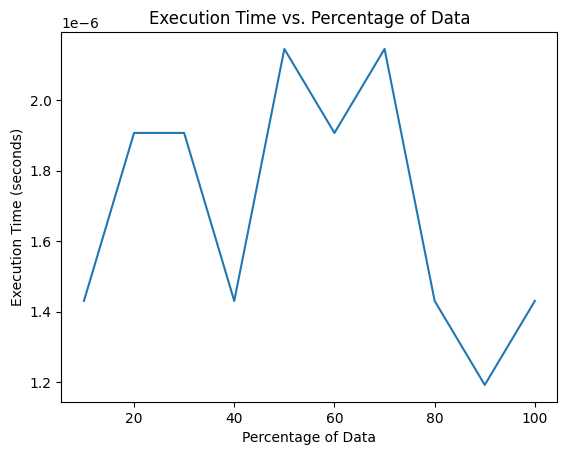

In [ ]:
import time
import pandas as pd

execution_times = []

for percentage in range(10, 110, 10):
    num_rows = int(taxi_data_main.count() * percentage / 100)

    subset_data = taxi_data_main.limit(num_rows)

    # Record start time
    start_time = time.time()


    # Record end time
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)

execution_times_df = pd.DataFrame({'Percentage': range(10, 110, 10), 'Execution Time (seconds)': execution_times})

import matplotlib.pyplot as plt

plt.plot(execution_times_df['Percentage'], execution_times_df['Execution Time (seconds)'])
plt.xlabel('Percentage of Data')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. Percentage of Data')
plt.show()
